In [1]:
from bs4 import BeautifulSoup as BS
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
% matplotlib inline
import seaborn as sns
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
from geopandas.tools import sjoin
from shapely.geometry import Point, Polygon

In [2]:
def scrape_table(url, class_):
    """Scrape first table given a website and class for table"""
    
    # request access to url
    request = urllib.request.Request(url)
    result = urllib.request.urlopen(request)
    
    # read in raw html
    result_text = result.read()
    
    # use beautiful soup to parse html
    soup = BS(result_text, "html.parser")
    
    # select table
    table = soup.find_all("table", class_ = class_)[0] # text is in list of lists for each table.
                                                       # index to select first (only) one
    
    # components of table are separated by tags, select just headers
    table_headers = table.find_all("th")
    
    # remove html and take just the text
    columns = [th.text for th in table_headers]
    
    # loop over rest of rows to get the data
    rows = list()
    for tr in table.find_all("tr")[1:]: # first index is headers so skip
        row_data = [td.text for td in tr.find_all("td")]
        rows.append(row_data)
    
    # construct df
    df = pd.DataFrame(rows, columns = columns)
    
    return(df)

In [3]:
earthquakes = scrape_table("https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900",
                           "sortable wikitable")

In [4]:
earthquakes.head()

,Origin (UTC),Present-day country and link to Wikipedia article,Lat,Long,Depth (km),Magnitude,Secondary Effects,PDE Shaking Deaths,PDE Total Deaths,Utsu Total Deaths,EM-DAT Total Deaths,Other Source Deaths
0,1900-05-11 17:23,Japan,38.700,141.100,5,7.0 MJMA,,,,,,
1,1900-07-12 06:25,Turkey,40.300,43.100,,5.9 Muk,,,,140,,
2,1900-10-29 09:11,Venezuela,11.000,-66.000,0,7.7 Mw,,,,,,
3,1901-02-15 00:00,China,26.000,100.100,0,6.5 Ms,,,,,,
4,1901-03-31 07:11,Bulgaria,43.400,28.700,,6.4 Muk,,,,4,,


In [5]:
# clean up the scraped table

earthquakes = earthquakes.replace("", np.nan) # change empty strings into NaNs
test = "(\[\d+\]|\(.*\)|\*|\+|\,)" # regex to remove footnotes
earthquakes["Other Source Deaths"] = earthquakes["Other Source Deaths"].str.replace(test, "")
earthquakes.tail() # check to make sure footnotes are removed

,Origin (UTC),Present-day country and link to Wikipedia article,Lat,Long,Depth (km),Magnitude,Secondary Effects,PDE Shaking Deaths,PDE Total Deaths,Utsu Total Deaths,EM-DAT Total Deaths,Other Source Deaths
1335,2011-03-11 14:46,Japan (see 2011 Tōhoku earthquake),38.322,142.369,24.4,9.0 Mw,T,NaN,NaN,NaN,NaN,15894
1336,2011-03-24 20:25,Burma (see 2011 Burma earthquake),NaN,NaN,NaN,6.8 Mw,NaN,NaN,NaN,NaN,NaN,150
1337,2011-04-07 14:32,Japan (see April 2011 Miyagi earthquake),38.2,140.0,66.0,7.1 Mw,NaN,NaN,NaN,NaN,NaN,NaN
1338,2011-09-18 12:40,India (see 2011 Sikkim earthquake),27.723,88.064,19.7,6.9 Mw,L,NaN,NaN,NaN,NaN,111
1339,2011-09-23 10:41,Turkey (see 2011 Van earthquake),38.6,43.5,7.2,7.1 Mw,NaN,NaN,NaN,NaN,NaN,601


In [6]:
# Some lat and longs are missing

earthquakes[(earthquakes["Lat"].isnull())|(earthquakes["Lat"] == "?")]

,Origin (UTC),Present-day country and link to Wikipedia article,Lat,Long,Depth (km),Magnitude,Secondary Effects,PDE Shaking Deaths,PDE Total Deaths,Utsu Total Deaths,EM-DAT Total Deaths,Other Source Deaths
413,1963-06-26 04:17,Macedonia (see 1963 Skopje earthquake),?,??,?,6.1 Mw,NaN,NaN,1100,NaN,NaN,None
439,1966-04-25 23:22,Uzbekistan (see 1966 Tashkent earthquake),NaN,NaN,NaN,5 ML,NaN,NaN,NaN,NaN,10[7]|,None
1319,2008-10-06 16:30,China (see 2008 Damxung earthquake),NaN,NaN,NaN,6.4 Mw,NaN,NaN,NaN,NaN,NaN,NaN
1320,2008-10-28 23:09,Pakistan (see 2008 Ziarat earthquake),NaN,NaN,NaN,6.4 Mw,NaN,NaN,NaN,NaN,NaN,215
1323,2009-07-09 11:19,China (see 2009 Yunnan earthquake),NaN,NaN,NaN,5.7 Mw,NaN,NaN,NaN,NaN,NaN,NaN
1324,2009-08-10 20:07,Japan (see 2009 Shizuoka earthquake),NaN,NaN,NaN,6.4 Mw,NaN,NaN,NaN,NaN,NaN,1
1325,2009-09-02 07:55,Indonesia (see 2009 West Java earthquake),NaN,NaN,NaN,7.0 Mw,NaN,NaN,NaN,NaN,NaN,79
1326,2009-09-29 17:48,Samoa (see 2009 Samoa earthquake and tsunami),NaN,NaN,8.1,8.1 Mw,NaN,NaN,NaN,NaN,NaN,189
1327,2009-09-30 10:16,Indonesia (see 2009 Padang earthquake),NaN,NaN,NaN,7.6 Mw,NaN,NaN,NaN,NaN,NaN,1115
1330,2010-03-08 02:32,Turkey (see 2010 Elâzığ earthquake),NaN,NaN,NaN,6.1 Mw,NaN,NaN,NaN,NaN,NaN,42


In [7]:
# Get rows where lat long is missing
inds = earthquakes[(earthquakes["Lat"].isnull())|(earthquakes["Lat"] == "?")].index.tolist()

# Look up lat and longs, add to lists
lats = [41.16,
        29.759,
        30.569,
        25.619,
        34.778,
        -7.778,
        -15.53,
        0.71,
        38.79,
        -34.301,
        33.165,
        -43.5834,
        24.71,
        20.705,
        42.1]

longs = [69.13,
         90.302,
         67.484,
         101.086,
         138.276,
         107.328,
         -171.87,
         99.97,
         40.03,
         -72.13,
         96.629,
         172.7012,
         97.994,
         99.949,
         21.4]

In [8]:
# assign missing values

for ind, lat, long in zip(inds, lats, longs):
    earthquakes.iloc[ind, earthquakes.columns.get_loc('Lat')] = lat
    earthquakes.iloc[ind, earthquakes.columns.get_loc('Long')] = long

In [9]:
# check to make sure replacements are correct

earthquakes.iloc[inds]

,Origin (UTC),Present-day country and link to Wikipedia article,Lat,Long,Depth (km),Magnitude,Secondary Effects,PDE Shaking Deaths,PDE Total Deaths,Utsu Total Deaths,EM-DAT Total Deaths,Other Source Deaths
413,1963-06-26 04:17,Macedonia (see 1963 Skopje earthquake),41.16,69.13,?,6.1 Mw,NaN,NaN,1100,NaN,NaN,None
439,1966-04-25 23:22,Uzbekistan (see 1966 Tashkent earthquake),29.759,90.302,NaN,5 ML,NaN,NaN,NaN,NaN,10[7]|,None
1319,2008-10-06 16:30,China (see 2008 Damxung earthquake),30.569,67.484,NaN,6.4 Mw,NaN,NaN,NaN,NaN,NaN,NaN
1320,2008-10-28 23:09,Pakistan (see 2008 Ziarat earthquake),25.619,101.086,NaN,6.4 Mw,NaN,NaN,NaN,NaN,NaN,215
1323,2009-07-09 11:19,China (see 2009 Yunnan earthquake),34.778,138.276,NaN,5.7 Mw,NaN,NaN,NaN,NaN,NaN,NaN
1324,2009-08-10 20:07,Japan (see 2009 Shizuoka earthquake),-7.778,107.328,NaN,6.4 Mw,NaN,NaN,NaN,NaN,NaN,1
1325,2009-09-02 07:55,Indonesia (see 2009 West Java earthquake),-15.53,-171.87,NaN,7.0 Mw,NaN,NaN,NaN,NaN,NaN,79
1326,2009-09-29 17:48,Samoa (see 2009 Samoa earthquake and tsunami),0.71,99.97,8.1,8.1 Mw,NaN,NaN,NaN,NaN,NaN,189
1327,2009-09-30 10:16,Indonesia (see 2009 Padang earthquake),38.79,40.03,NaN,7.6 Mw,NaN,NaN,NaN,NaN,NaN,1115
1330,2010-03-08 02:32,Turkey (see 2010 Elâzığ earthquake),-34.301,-72.13,NaN,6.1 Mw,NaN,NaN,NaN,NaN,NaN,42


In [10]:
# Other Source Deaths columns has extra spaces and multiple entries from different reports
# loop over column to consolidate values to single int

means = []
for row in earthquakes["Other Source Deaths"]:
    #print("\noriginal: {}".format(type(row)))
    if isinstance(row, str):
        int_list = row.strip().split(" ")
        #print("transformed: {}".format(int_list))
        total = sum(list(map(int, int_list)))
        number = len(int_list)
        mean = total/number
        means.append(mean)
        #print(mean)
    else:
        means.append(row)
        
earthquakes["Other Source Deaths"] = means

In [11]:
for col in ['EM-DAT Total Deaths', 'Magnitude']:
    earthquakes[col] = earthquakes[col].str.extract('(\d+\.\d*)', expand=True)

In [12]:
# New column that is max of all death columns

death_cols = ["PDE Total Deaths", "Utsu Total Deaths", "EM-DAT Total Deaths", "Other Source Deaths"]
for col in death_cols:
    earthquakes[col] = pd.to_numeric(earthquakes[col])
subdf = earthquakes[death_cols]
earthquakes["deaths"] = subdf.max(axis = 1)
earthquakes.head()

,Origin (UTC),Present-day country and link to Wikipedia article,Lat,Long,Depth (km),Magnitude,Secondary Effects,PDE Shaking Deaths,PDE Total Deaths,Utsu Total Deaths,EM-DAT Total Deaths,Other Source Deaths,deaths
0,1900-05-11 17:23,Japan,38.700,141.100,5,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1900-07-12 06:25,Turkey,40.300,43.100,NaN,5.9,NaN,NaN,NaN,140.0,NaN,NaN,140.0
2,1900-10-29 09:11,Venezuela,11.000,-66.000,0,7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1901-02-15 00:00,China,26.000,100.100,0,6.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1901-03-31 07:11,Bulgaria,43.400,28.700,NaN,6.4,NaN,NaN,NaN,4.0,NaN,NaN,4.0


In [13]:
# More cleaning

earthquakes.columns = ["UTC", "Country", "lat", "lng", "Depth_km", "Mag", "Secondary_Effects", "PDE_Shaking_Deaths", "PDE_Deaths", "Utsu_Deaths", "EM-DAT_Deahts", "Other_Deaths", "Max_Deaths"]
test2="(\s\(.*)"
earthquakes['Country']= earthquakes['Country'].str.replace(test2, "")

In [14]:
# convert timestap to datetime and separate out into component parts

earthquakes["UTC"] = pd.to_datetime(earthquakes["UTC"])
earthquakes["Year"] = pd.DatetimeIndex(earthquakes["UTC"]).year
earthquakes["Month"] = pd.DatetimeIndex(earthquakes["UTC"]).month
earthquakes["Month"] = earthquakes.Month.map("{:02}".format)
earthquakes["Day"] = pd.DatetimeIndex(earthquakes["UTC"]).day

In [15]:
# scrape table about volcanoes

volcanoes = scrape_table(url = "http://volcano.oregonstate.edu/volcano_table", class_ = "views-table cols-6")
volcanoes.head(1)

,Volcano Name,Country,Type,Latitude (dd),Longitude (dd),Elevation (m)
0,\nAbu,\n Japan,\n Shield,\n 34.50,\n 131.60,\n 641


In [16]:
# clean lat and long columns and convert to geodataframe

volcanoes.columns = ["Name", "Country", "Type", "lat", "lng", "Elevation"]
test_v = "(\n|\n\s)"
volcanoes = volcanoes.replace(to_replace = test_v, value = "", regex = True)
volcanoes["lat"] = volcanoes["lat"].str.strip()
volcanoes["lng"] = volcanoes["lng"].str.strip()
volcanoes["lat"] = pd.to_numeric(volcanoes["lat"])
volcanoes["lng"] = pd.to_numeric(volcanoes["lng"])

geometry = [Point(xy) for xy in zip(volcanoes.lng, volcanoes.lat)]
crs = {"init": "epsg:4326"} 
volcanoes_gdf = gpd.GeoDataFrame(volcanoes, crs=crs, geometry=geometry)

In [17]:
# Get top 25 countries based on number of earthquakes

quakes_country = earthquakes.groupby("Country").agg(len)
quakes_country = quakes_country.reset_index()
quakes_country_25 = quakes_country.nlargest(25, columns = "UTC")

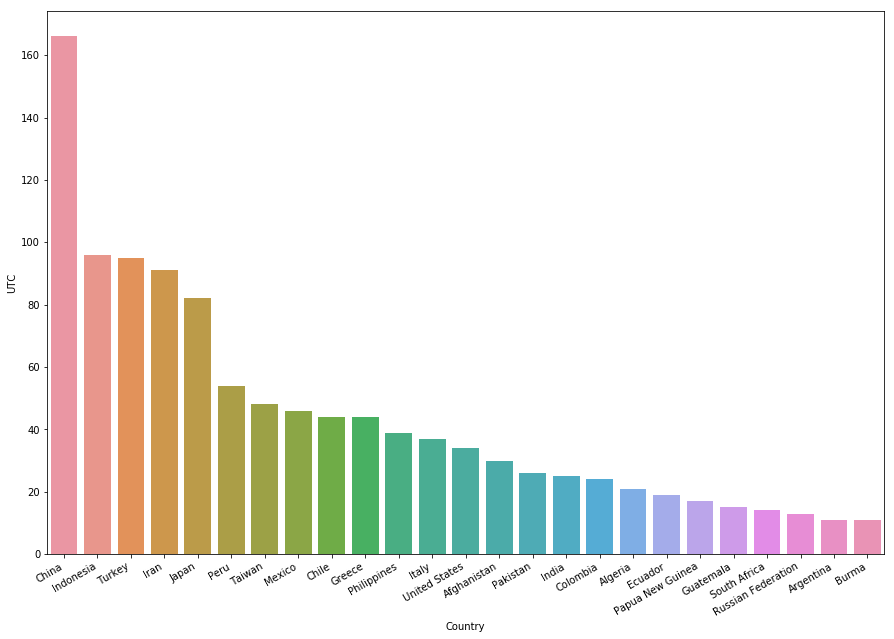

In [18]:
f, ax = plt.subplots(figsize=(15, 10))
quake_count = sns.barplot(quakes_country_25.Country, quakes_country_25.UTC) # since its a group by just chose random column
quake_count.set_xticklabels(quake_count.get_xticklabels(), rotation=30, ha="right");

In [19]:
# read in geojsons for world map and tectonic plate boundaries as geodataframes

plates_gdf = gpd.read_file("data/PB2002_plates.json")
countries_gdf = gpd.read_file("data/countries.geojson")

In [20]:
# convert earthquakes df to geodataframe

earthquakes["lat"] = pd.to_numeric(earthquakes["lat"])
earthquakes["lng"] = pd.to_numeric(earthquakes["lng"])

geometry = [Point(xy) for xy in zip(earthquakes.lng, earthquakes.lat)]
earthquakes_gdf = gpd.GeoDataFrame(earthquakes, crs=crs, geometry=geometry)

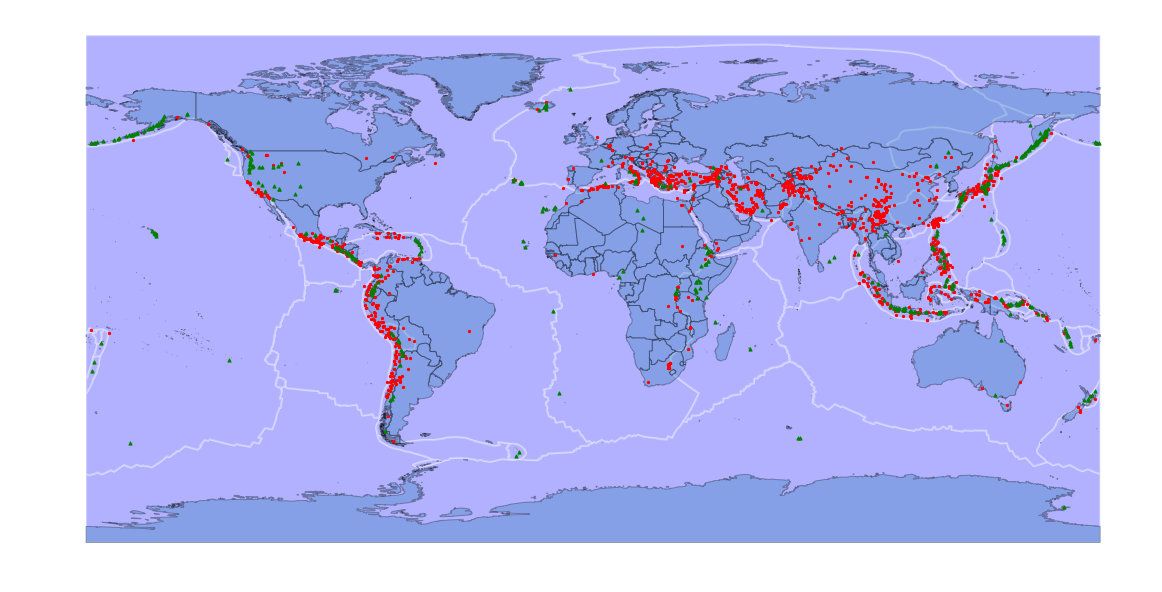

In [21]:
fig, ax = plt.subplots(figsize = (20, 20))
ax.set_aspect('equal')
plates_gdf.plot(ax=ax, color='blue', edgecolor='white', alpha = 0.3, lw = 2.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha = 0.3)
earthquakes_gdf.plot(ax=ax, markersize = 5, color = "red")
volcanoes_gdf.plot(ax=ax, markersize = 10, color = "green", marker = "^")
plt.axis('off');

# Run this if you want to save the map
#plt.tight_layout()
#plt.savefig("quakes_world_map.png", dpi=80, orientation='landscape')

## Find the closest tectonic plate boundary type for each earthquake to determine if earthquakes are more likely to occur closer to particular boundary type

In [22]:
# read in geojson with tectonic plate boundary types as geodataframe

boundaries_gdf = gpd.read_file("data/PB2002_steps.json")

In [23]:
# get linestrings for each boundary type

boundary_types = boundaries_gdf["STEPCLASS"].unique() # will be refering to this list later so bind to variable
boundary_list = list()
for boundary in boundary_types:
    boundary_list.append(boundaries_gdf[boundaries_gdf["STEPCLASS"] == boundary].geometry)

# linestrings for all boundaries for downstream comparison
boundaries_geo = boundaries_gdf["geometry"]

# get coordinates of earthquakes to measure against
earthquakes_geo = earthquakes_gdf["geometry"]

In [24]:
def quake_dist(geoseries):
    """find minimum distance between earthquake and other feature"""
    dist_list = []
    for quake in earthquakes_geo:
        dist = np.min([quake.distance(feature) for feature in geoseries])
        dist_list.append(dist)
    return dist_list

In [25]:
# This one can take a while to run

total_bound_dist = []

for geoseries in (boundary_list + [boundaries_geo]):
    min_distances = quake_dist(geoseries)
    total_bound_dist.append(min_distances)

In [26]:
# Add min distance columns to earthquakes gdf

boundary_distances = pd.DataFrame(total_bound_dist)
boundary_distances = boundary_distances.transpose()
boundary_distances.columns = np.append(boundary_types, ["boundaries"])
earthquakes_dist = pd.concat([earthquakes_gdf, boundary_distances], axis=1)

In [27]:
# Find boundary type that matches all boundaries, indicating closest boundary type. Add as new column

conditions = list()
for boundary in boundary_types:
    conditions.append(boundary_distances["boundaries"] == boundary_distances[boundary])
earthquakes_dist["closest_boundary"] = np.select(conditions, boundary_types, default = np.nan)

In [28]:
earthquakes_dist.head()

,UTC,Country,lat,lng,Depth_km,Mag,Secondary_Effects,PDE_Shaking_Deaths,PDE_Deaths,Utsu_Deaths,...,geometry,OTF,OSR,OCB,CTF,CRB,CCB,SUB,boundaries,closest_boundary
0,1900-05-11 17:23:00,Japan,38.7,141.1,5,7.0,NaN,NaN,NaN,NaN,...,POINT (141.1 38.7),4.177337,11.473059,2.803642,4.131410,11.549234,3.259099,2.877975,2.803642,OCB
1,1900-07-12 06:25:00,Turkey,40.3,43.1,NaN,5.9,NaN,NaN,NaN,140.0,...,POINT (43.1 40.3),25.071416,14.229416,21.644313,2.427798,7.533582,2.239038,10.216419,2.239038,CCB
2,1900-10-29 09:11:00,Venezuela,11.0,-66.0,0,7.7,NaN,NaN,NaN,NaN,...,POINT (-66 11),5.200229,12.514348,9.083121,0.346223,0.965733,3.412162,5.519615,0.346223,CTF
3,1901-02-15 00:00:00,China,26.0,100.1,0,6.5,NaN,NaN,NaN,NaN,...,POINT (100.1 26),14.009282,13.865524,13.872035,3.020695,5.183048,3.131844,14.677679,3.020695,CTF
4,1901-03-31 07:11:00,Bulgaria,43.4,28.7,NaN,6.4,NaN,NaN,NaN,4.0,...,POINT (28.7 43.4),11.509747,7.039563,10.288443,2.728627,2.871915,9.939515,8.001041,2.728627,CTF


### Need to normalize to overall length of boundary since some boundary types are more expansive than others

In [29]:
def total_boundary_length(geoseries):
    """sum up all linestrings in a geoseries to get total length"""
    lengths = []
    for line in geoseries:
        length = line.length
        lengths.append(length)
        total_length = np.sum(lengths)
    return total_length

In [30]:
# Calculate total boundary length for each boundary type

boundaries_length = []

for geoseries in boundary_list:
    total_length = total_boundary_length(geoseries)
    boundaries_length.append(total_length)

In [31]:
# How many earthquakes are associated with each boundary?

bound_dist_count = [len(earthquakes_dist[earthquakes_dist["closest_boundary"] == boundary]) for boundary in boundary_types]

In [32]:
# Calculate normalized distance to each boundary

norm_bound_dist = np.divide(bound_dist_count, boundaries_length)

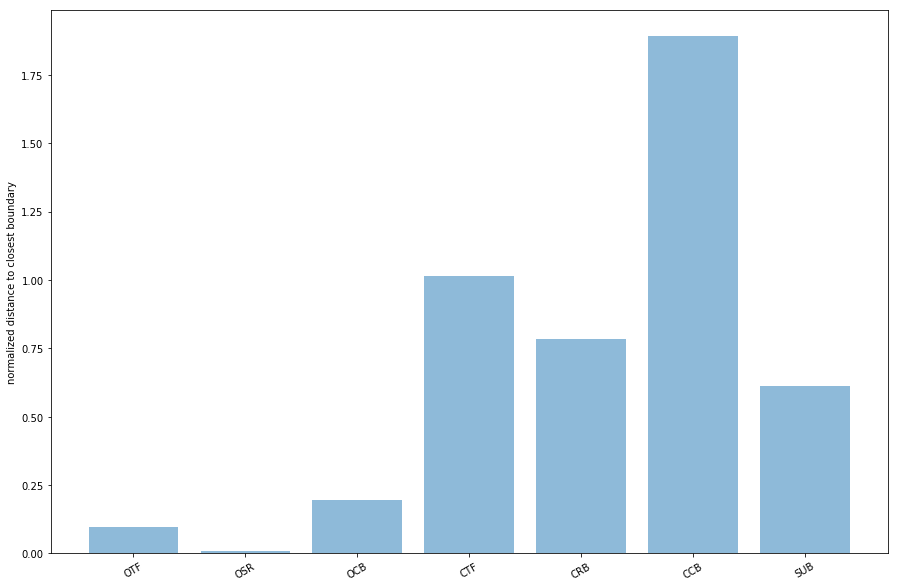

In [33]:
# Are some boundaries more associated with earthquakes than others?

y_pos = np.arange(len(boundary_types))

plt.figure(figsize=(15,10))
plt.bar(y_pos, norm_bound_dist, alpha=0.5)
plt.xticks(y_pos, boundary_types, rotation = 30)
plt.ylabel('normalized distance to closest boundary');

## Looks like Continential Convergent Boundaries (CCB) are closest to the most number of deadly earthquakes when normalized by distance

### Plot the earthquakes on a map color coded by closest boundary

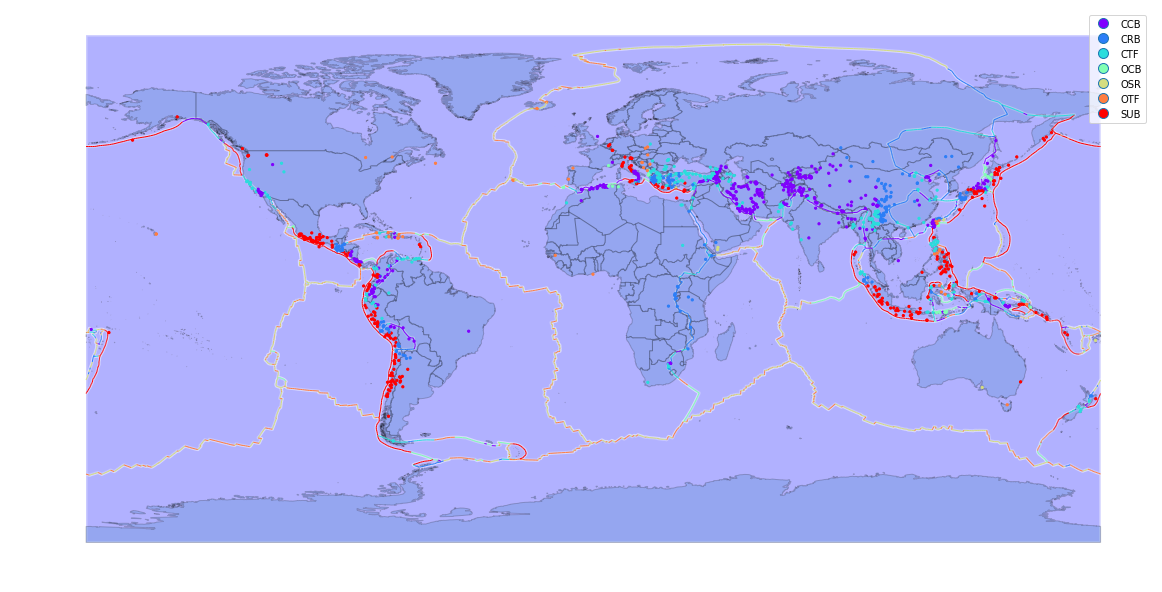

In [34]:
fig, ax = plt.subplots(figsize = (20, 20))
ax.set_aspect('equal')
plates_gdf.plot(ax=ax, color='blue', edgecolor='white', alpha = 0.3, lw = 3.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha = 0.2)
boundaries_gdf.plot(ax=ax, column = "STEPCLASS", cmap = "rainbow", lw = 1, legend = True)
earthquakes_dist.plot(ax=ax, markersize = 5, column = "closest_boundary", cmap = "rainbow")
plt.axis('off');

# Run this if you want to save the map
#plt.tight_layout()
#plt.savefig("quakes_world_map.png", dpi=80, orientation='landscape')

# Now for volcanoes

In [35]:
# Some null coordinates, just drop them. Sorry too lazy to look them up.

volcanoes_gdf.loc[volcanoes_gdf["lat"].isnull()]

,Name,Country,Type,lat,lng,Elevation,geometry
86,Columbia River Flood Basalts,USA,Flood Basalt,NaN,NaN,,POINT (nan nan)
96,Deccan Traps,India,Flood Basalt,NaN,NaN,,POINT (nan nan)
263,Navajo Volcanic Field,United States,Volcanic Field,NaN,NaN,2740,POINT (nan nan)
276,Oahu,United States,Shield,NaN,NaN,1220,POINT (nan nan)


In [36]:
volcanoes_gdf = volcanoes_gdf.drop(volcanoes_gdf.loc[volcanoes_gdf["lat"].isnull()].index)

In [37]:
vol_types = volcanoes_gdf["Type"].unique()

In [38]:
# get coordinates for each volcano type, same as with volcanoes

vol_types = volcanoes_gdf["Type"].unique()
vol_list = list()
for vol in vol_types:
    vol_list.append(volcanoes_gdf[volcanoes_gdf["Type"] == vol].geometry)

# linestrings for all boundaries for downstream comparison
vol_geo = volcanoes_gdf["geometry"]

In [39]:
total_vol_dist = []

for geoseries in (vol_list + [vol_geo]):
    min_distances = quake_dist(geoseries)
    total_vol_dist.append(min_distances)

In [40]:
# Add min distance columns to earthquakes gdf

vol_distances = pd.DataFrame(total_vol_dist)
vol_distances = vol_distances.transpose()
vol_distances.columns = np.append(vol_types, ["volcanoes"])
earthquakes_dist = pd.concat([earthquakes_dist, vol_distances], axis=1)

In [41]:
# Find boundary type that matches all boundaries, indicating closest boundary type. Add as new column

conditions = list()
for vol in vol_types:
    conditions.append(vol_distances["volcanoes"] == vol_distances[vol])
earthquakes_dist["closest_volcano"] = np.select(conditions, vol_types, default = np.nan)

In [42]:
# How many of each volcano are there and how many earthquakes are associated with each type?
# This is a little round about to get the values but it puts them in the correct order which makes dividing easier

vol_number = [len(vol) for vol in vol_list]
vol_dist_count = [len(earthquakes_dist[earthquakes_dist["closest_volcano"] == vol]) for vol in vol_types]

In [43]:
norm_vol_dist = np.divide(vol_dist_count, vol_number)

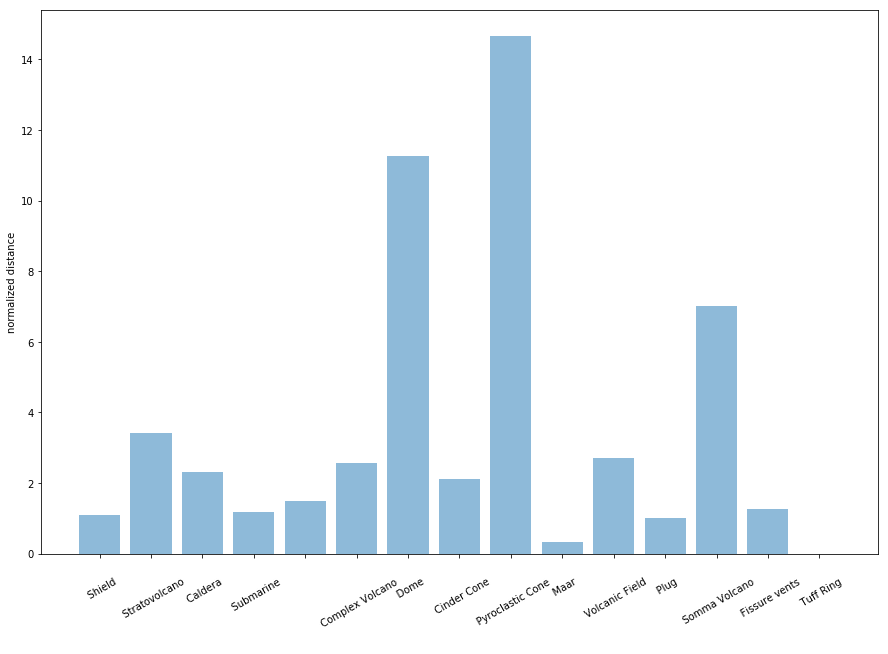

In [44]:
y_pos = np.arange(len(vol_types))
 
plt.figure(figsize=(15,10))
plt.bar(y_pos, norm_vol_dist, alpha=0.5)
plt.xticks(y_pos, vol_types, rotation = 30)
plt.ylabel('normalized distance');

### Looks like Pyroclastic Cones are closest to the most number of earthquakes when normalized by distance

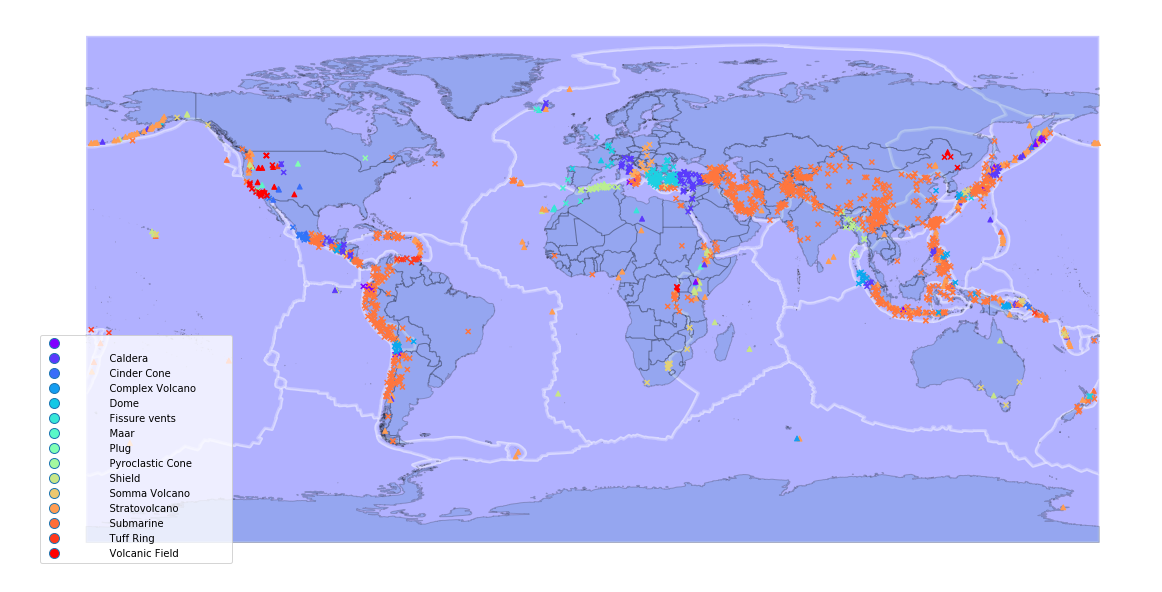

In [45]:
fig, ax = plt.subplots(figsize = (20, 20))
ax.set_aspect('equal')
plates_gdf.plot(ax=ax, color='blue', edgecolor='white', alpha = 0.3, lw = 3.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha = 0.2)
volcanoes_gdf.plot(ax=ax, column = "Type", cmap = "rainbow", markersize = 25, legend = True, marker = "^")
earthquakes_dist.plot(ax=ax, markersize = 25, column = "closest_volcano", cmap = "rainbow", marker = "x")
plt.axis('off');

# Run this if you want to save the map
#plt.tight_layout()
#plt.savefig("quakes_world_map.png", dpi=80, orientation='landscape')

^ Probably should functionize this, its basically the same as with plate boundaries

# Is this specific to deadly earthquakes or this dataset? Repeat test with new dataset

### Smithosnian has much more extensive list of earthquakes. They also have eruptions but haven't incorporated that yet. https://volcano.si.edu/E3/

In [46]:
# These data were cleaned and prepared previously, read in here for analysis

boundary_distances2 = pd.read_csv("data/Earthquake_boundary_distances2")
boundary_distances2 = boundary_distances2.drop("Unnamed: 0", axis = 1)

In [47]:
boundary_distances2.head()

,date,depth,mag,id,place,geometry,date.1,depth.1,mag.1,id.1,...,geometry.1,boundaries_geo2,sub_geo2,ccb_geo2,crb_geo2,ctf_geo2,ocb_geo2,osr_geo2,otf_geo2,closest_boundary2
0,19600102,15.0,6.3,iscgem877909,Bouvet Island region,POINT (-1.89 -55.877),19600102,15.0,6.3,iscgem877909,...,POINT (-1.89 -55.877),0.221410,22.051172,32.701335,30.812117,26.219884,27.611902,0.355460,0.221410,OTF
1,19600103,15.0,5.7,iscgem877920,"northern Xinjiang, China",POINT (84.542 43.7),19600103,15.0,5.7,iscgem877920,...,POINT (84.542 43.7),14.366975,30.915059,14.366975,18.764151,14.530203,27.458720,32.675968,27.458720,CCB
2,19600104,15.0,6.1,iscgemsup877930,Djibouti,POINT (42.609 11.374),19600104,15.0,6.1,iscgemsup877930,...,POINT (42.609 11.374),0.346336,24.585383,18.971821,0.346336,1.259295,14.433952,1.221475,2.743895,CRB
3,19600107,55.0,5.5,iscgem877960,"Nicobar Islands, India region",POINT (94.547 6.352),19600107,55.0,5.5,iscgem877960,...,POINT (94.547 6.352),0.259956,2.108272,8.276883,1.254022,0.259956,4.269910,0.487571,0.855725,CTF
4,19600107,15.0,5.6,iscgem877954,"Nicobar Islands, India region",POINT (94.756 6.418),19600107,15.0,5.6,iscgem877954,...,POINT (94.756 6.418),0.054731,2.327099,8.166058,1.221409,0.054731,4.319760,0.492587,0.732100,CTF


In [48]:
#boundary_distances2.columns.str.contains("geo2")

In [49]:
# Data are in a different layout with different labels so need to adjust that

boundary_distance_list = ["sub_geo2", "ccb_geo2", "crb_geo2", "ctf_geo2", "ocb_geo2", "osr_geo2", "otf_geo2"]

conditions = [boundary_distances2['boundaries_geo2'] == boundary_distances2[bound] for bound in boundary_distance_list]
choices = ['SUB', 'CCB', 'CRB', 'CTF', 'OCB', 'OSR', 'OTF']

boundary_distances2['closest_boundary2'] = np.select(conditions, choices, default=np.nan)

In [50]:
boundary_type_list = ["SUB", "CCB", "CRB", "CTF", "OCB", "OSR", "OTF"]

boundaries_length = [total_boundary_length(boundaries_gdf[boundaries_gdf.STEPCLASS == bound].geometry) for bound in boundary_type_list]

In [51]:
bound_dist_count2 = [len(boundary_distances2[boundary_distances2["closest_boundary2"] == bound]) for bound in boundary_type_list]

In [52]:
norm_bound_dist2 = np.divide(bound_dist_count2, boundaries_length)

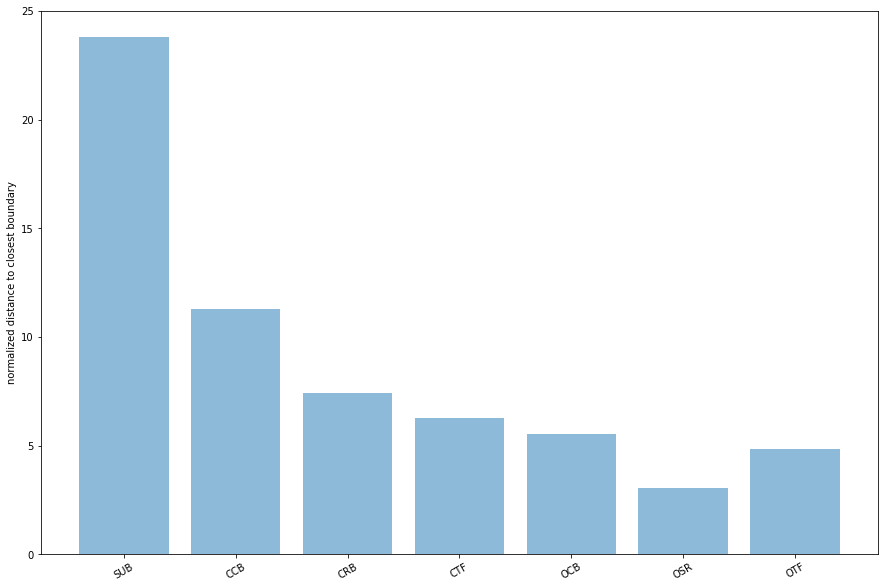

In [53]:
y_pos = np.arange(len(boundary_type_list))
 
plt.figure(figsize=(15,10))
plt.bar(y_pos, norm_bound_dist2, alpha=0.5)
plt.xticks(y_pos, boundary_type_list, rotation = 30)
plt.ylabel('normalized distance to closest boundary');

### Looks like when considering all earthquakes (not just deadly ones) there are more that occur closest to subduction zones, rather than continental convergent boundaries (as with deadly earthquakes)

In [54]:
# read in earthquake data from smithsonian to plot on map

earthquakes2_gdf = gpd.read_file("data/earthquakes2.GeoJSON")
earthquakes2_gdf["closest_boundary2"] = boundary_distances2["closest_boundary2"]

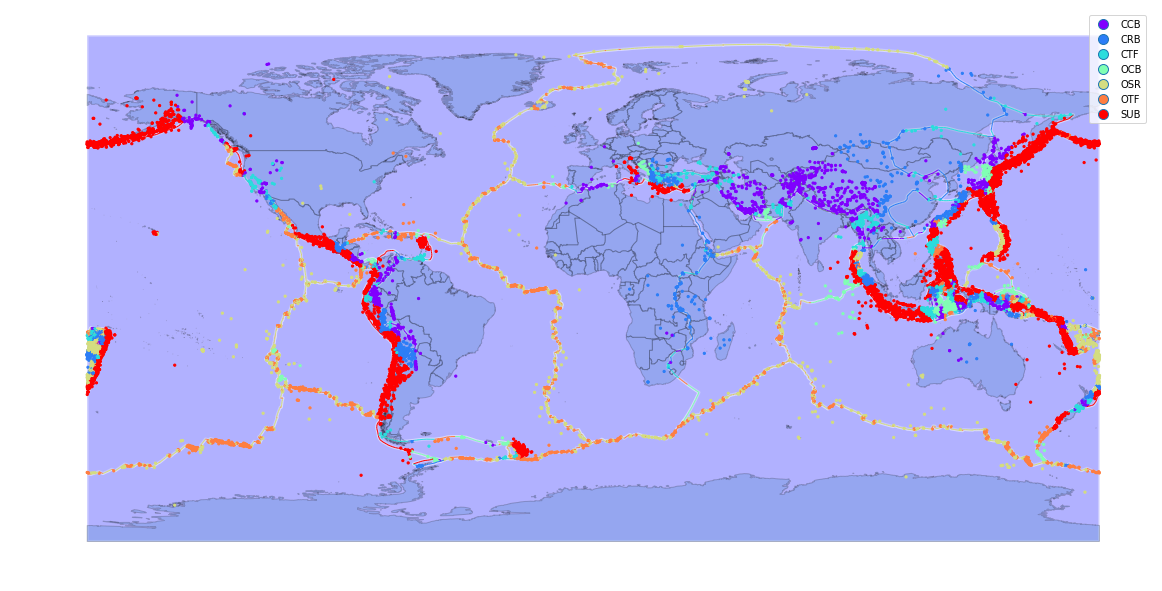

In [55]:
fig, ax = plt.subplots(figsize = (20, 20))
ax.set_aspect('equal')
plates_gdf.plot(ax=ax, color='blue', edgecolor='white', alpha = 0.3, lw = 3.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha = 0.2)
boundaries_gdf.plot(ax=ax, column = "STEPCLASS", cmap = "rainbow", lw = 1, legend = True)
earthquakes2_gdf.plot(ax=ax, markersize = 5, column = "closest_boundary2", cmap = "rainbow")
plt.axis('off');

# Run this if you want to save the map
#plt.tight_layout()
#plt.savefig("quakes_world_map.png", dpi=80, orientation='landscape')

In [56]:
# These data were cleaned and prepared previously, read in here for analysis

quake_vol_dist_smith_gdf = gpd.read_file("data/quake_vol_dist_smith.GeoJSON")

In [57]:
quake_vol_dist_smith_gdf.head()

,date,depth,mag,id,place,vol,strato,caldera,shield,complex,...,vol_field,cinder,dome,fissure_vents,somma,maar,proclastic,tuff,plug,geometry
0,19600102,15.0,6.3,iscgem877909,Bouvet Island region,21.468662,24.633615,71.653217,21.468662,69.757167,...,64.227574,108.947317,96.841323,85.105870,98.064531,75.537533,93.487813,148.428379,143.755082,POINT (-1.89 -55.877)
1,19600103,15.0,5.7,iscgem877920,"northern Xinjiang, China",29.134168,29.134168,43.531613,47.948883,40.541596,...,41.879953,71.755708,48.031874,70.726568,67.794319,58.349150,32.768679,196.502000,189.244140,POINT (84.542 43.7)
2,19600104,15.0,6.1,iscgemsup877930,Djibouti,2.197675,2.197675,3.891791,2.534868,10.883218,...,17.094000,113.938904,29.650929,31.733117,40.756876,5.402597,46.506752,157.913096,151.009631,POINT (42.609 11.374)
3,19600107,55.0,5.5,iscgem877960,"Nicobar Islands, India region",2.293132,8.167342,5.707195,46.532083,2.293132,...,52.838450,61.918000,45.666978,81.880541,70.651723,56.222647,5.975344,209.857128,202.884885,POINT (94.547 6.352)
4,19600107,15.0,5.6,iscgem877954,"Nicobar Islands, India region",2.179803,8.035020,5.597117,46.325793,2.179803,...,52.660799,61.726635,45.459315,82.064741,70.442976,56.429604,5.936982,210.051070,203.077722,POINT (94.756 6.418)


In [58]:
# get column headers refering to distance from volcano type

vol_dist_list = quake_vol_dist_smith_gdf.drop(["date", "depth", "mag", "id", "place", "vol", "geometry"], axis = 1).columns

In [59]:
# label closest volcano

conditions = [quake_vol_dist_smith_gdf['vol'] == quake_vol_dist_smith_gdf[vol] for vol in vol_dist_list]

quake_vol_dist_smith_gdf['closest_vol'] = np.select(conditions, vol_dist_list, default=np.nan)

In [60]:
# count number of earthquakes associated with a given volcano type

vol_dist_count_2 = [len(quake_vol_dist_smith_gdf[quake_vol_dist_smith_gdf["closest_vol"] == vol]) for vol in vol_dist_list]


In [61]:
# Count total number of each type of volcano

vol_number_2 = [len(volcanoes_gdf[volcanoes_gdf.Type.str.contains(vol, case = False)]) for vol in vol_dist_list]

In [62]:
# normalize the data by dividing the number of earthquakes associated with a volcano type by
# the total number of volcanoes of that type

norm_vol_dist_2 = list()

for dist, num in zip(vol_dist_count_2, vol_number_2):
    if num == 0:
         norm_dist = 0
    else:
         norm_dist = np.divide(dist, num)
    norm_vol_dist_2.append(norm_dist)

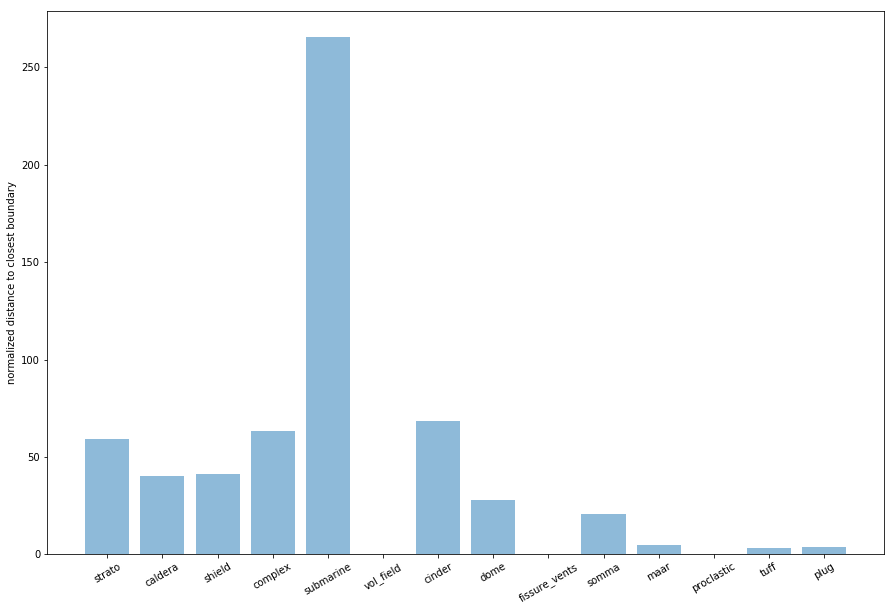

In [63]:
y_pos = np.arange(len(vol_dist_list))
 
plt.figure(figsize=(15,10))
plt.bar(y_pos, norm_vol_dist_2, alpha=0.5)
plt.xticks(y_pos, vol_dist_list, rotation = 30)
plt.ylabel('normalized distance to closest boundary');

### Again it looks like things are different when looking at all earthquakes. Closest volcano type is by far submarine and pyroclastic is never the closest

In [64]:
earthquakes2_gdf["closest_vol"] = quake_vol_dist_smith_gdf['closest_vol']

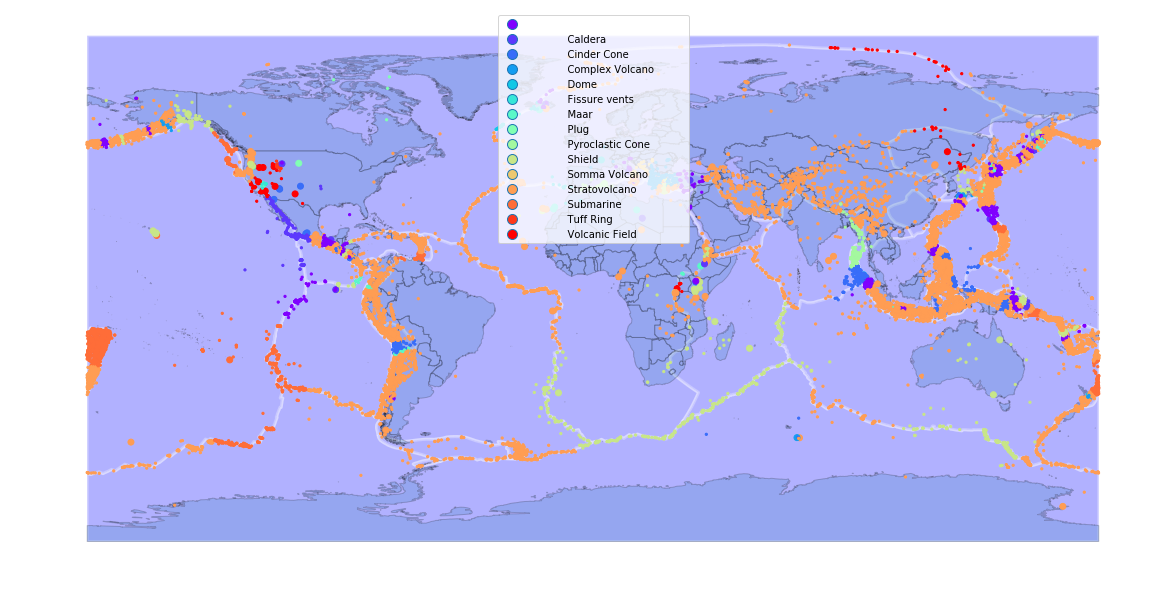

In [65]:
fig, ax = plt.subplots(figsize = (20, 20))
ax.set_aspect('equal')
plates_gdf.plot(ax=ax, color='blue', edgecolor='white', alpha = 0.3, lw = 3.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha = 0.2)
volcanoes_gdf.plot(ax=ax, column = "Type", cmap = "rainbow", lw = 1, legend = True)
earthquakes2_gdf.plot(ax=ax, markersize = 5, column = "closest_vol", cmap = "rainbow")
plt.axis('off');

# Run this if you want to save the map
#plt.tight_layout()
#plt.savefig("quakes_world_map.png", dpi=80, orientation='landscape')

___

# Now lets see what we can learn. Can we build a model to predict where earthquakes will occur?

In [66]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

In [67]:
# Get rid of non-numeric columns
# UTC also looks like bad format so remove
# Depth has lots of nans so remove
# Magnitude and datetime info are dropped for downstream purposes

ML_df = earthquakes_dist.drop(["Secondary_Effects", "PDE_Shaking_Deaths", "PDE_Deaths", "Utsu_Deaths",
                               "EM-DAT_Deahts", "Other_Deaths", "Max_Deaths", "Country", "closest_boundary",
                               "closest_volcano", "geometry", "UTC", "Depth_km", "Mag", "Year",
                               "Month", "Day", ""], axis = 1)

In [68]:
ML_df[ML_df.columns] = ML_df[ML_df.columns].apply(pd.to_numeric, errors='coerce')

In [69]:
# Any null values?

ML_df[ML_df.isnull().any(axis=1)]

# looks good so move on

,lat,lng,OTF,OSR,OCB,CTF,CRB,CCB,SUB,boundaries,...,Dome,Cinder Cone,Pyroclastic Cone,Maar,Volcanic Field,Plug,Somma Volcano,Fissure vents,Tuff Ring,volcanoes


In [70]:
#Train model for lat lng

y = ML_df[["lat", "lng"]]
X = ML_df.drop(["lat", "lng"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Create the regressor
lin_reg = LinearRegression()

# Fit the regressor to the training data
lin_reg.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = lin_reg.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(lin_reg.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(lin_reg, X, y, cv=5)
print("Cross-Validation scores: ", cv_scores, "\nMean CV: ", np.mean(cv_scores))

R^2: 0.9857099978604292
Root Mean Squared Error: 7.185343304836118
Cross-Validation scores:  [0.9946315  0.99412168 0.99400897 0.9932692  0.99246656] 
Mean CV:  0.9936995839586714


### Score (R^2) is extremely high so most likely the model is overfit. In the futre need to tune model and possibly impose some penalties. For now, rerun to generate model on smithsonian dataset

In [71]:
# Separate lat and long into separate columns from geometry column

lat = []
lng = []
for point in quake_vol_dist_smith_gdf.geometry:
    lng.append(point.x)
    lat.append(point.y)
quake_vol_dist_smith_gdf["lat"] = lat
quake_vol_dist_smith_gdf["lng"] = lng

In [72]:
# drop geometry for model purposes

quake_vol_dist_smith = quake_vol_dist_smith_gdf.drop("geometry", axis = 1)

In [73]:
# Combine info for boundary and volcano distances

ML_df_smith = pd.merge(left = quake_vol_dist_smith, right = boundary_distances2, how = "inner")

In [74]:
# get rid of non-numeric, duplicate, incomplete, and unused columns

ML_df_smith = ML_df_smith.drop(["date", "depth", "mag", "id", "place", "geometry", "date.1", "depth.1", "mag.1", "id.1", "place.1", "geometry.1", "closest_vol", "closest_boundary2"], axis = 1)

In [75]:
# Rerun same pipeline on smithsonian data

y_2 = ML_df_smith[["lat", "lng"]]
X_2 = ML_df_smith.drop(["lat", "lng"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size = 0.3, random_state=42)

lin_reg_2 = LinearRegression()

lin_reg_2.fit(X_train, y_train)

y_pred_2 = lin_reg_2.predict(X_test)

print("R^2: {}".format(lin_reg_2.score(X_test, y_test)))
rmse_2 = np.sqrt(mean_squared_error(y_test, y_pred_2))
print("Root Mean Squared Error: {}".format(rmse_2))

cv_scores_2 = cross_val_score(lin_reg_2, X_2, y_2, cv=5)
print("Cross-Validation scores: ", cv_scores_2, "\nMean CV: ", np.mean(cv_scores_2))

R^2: 0.9958917523269544
Root Mean Squared Error: 5.85211548775362
Cross-Validation scores:  [0.99579827 0.99617535 0.99600482 0.99588665 0.99597421] 
Mean CV:  0.9959678635687442


### Still looks overfit but lets perservere and see if we can learn anything more

***

# Does the model predict earthquakes in the same area where fracking occurs?

**_Data were cleaned, prepared, and distances calculated for volcanoes and plates previosuly. They are imported here for analysis_**

*Find where got this data!*

In [76]:
OK_2015_vol = gpd.read_file("data/OK_2015_vol_dist.GeoJSON")
OK_2015_vol = OK_2015_vol.drop("geometry", axis=1)
OK_2015_vol.head()

,latitude,longitude,vol,strato,caldera,shield,complex,submarine,vol_field,cinder,dome,fissure_vents,somma,maar,proclastic,tuff,plug
0,36.36558,-97.07604,7.014464,17.256596,15.806030,25.247583,22.566722,34.290644,9.313559,7.014464,60.864697,82.652354,111.594977,20.384464,101.161535,16.592949,11.221870
1,36.65549,-97.63704,6.456227,17.504247,15.175672,24.627936,22.997642,33.671191,8.869837,6.456227,60.235773,83.087588,112.144392,19.816310,101.719913,15.961588,10.630173
2,36.67116,-97.61475,6.479022,17.521182,15.186807,24.644804,23.006450,33.688296,8.896078,6.479022,60.250517,83.061418,112.121536,19.838314,101.697507,15.974692,10.633306
3,36.88717,-97.68763,6.417274,17.732763,15.014532,24.513893,23.234220,33.559263,8.902446,6.417274,60.101906,83.060556,112.186586,19.762813,101.769025,15.815030,10.424059
4,36.93193,-97.49207,6.615504,17.789006,15.161756,24.689419,23.223368,33.735606,9.101112,6.615504,60.266654,82.861001,111.989584,19.958121,101.573243,15.972719,10.523948


In [77]:
OK_2015_bound = gpd.read_file("data/OK_2015_bound_dist.GeoJSON")
OK_2015_bound = OK_2015_bound.drop("geometry", axis=1)
OK_2015_bound.head()

,latitude,longitude,boundaries_geo,sub_geo,ccb_geo,crb_geo,ctf_geo,ocb_geo,osr_geo,otf_geo
0,36.36558,-97.07604,16.699619,17.564141,19.721321,17.763003,17.329627,17.564141,16.699619,16.699619
1,36.65549,-97.63704,16.469975,17.502359,19.201649,17.312037,16.981989,17.502359,16.469975,16.469975
2,36.67116,-97.61475,16.497004,17.527447,19.225869,17.338056,17.009134,17.527447,16.497004,16.497004
3,36.88717,-97.68763,16.589986,17.673044,19.184520,17.336404,17.056117,17.673044,16.589986,16.589986
4,36.93193,-97.49207,16.763708,17.813665,19.384562,17.536036,17.247005,17.813665,16.763708,16.763708


In [78]:
ML_df_OK = pd.merge(left = OK_2015_bound, right = OK_2015_vol, how = "inner")

In [79]:
y_OK = ML_df_OK[["latitude", "longitude"]]
X_OK = ML_df_OK.drop(["latitude", "longitude"], axis = 1)

y_pred_2_OK = lin_reg_2.predict(X_OK)

print("R^2: {}".format(lin_reg_2.score(X_OK, y_OK)))
rmse_2_OK = np.sqrt(mean_squared_error(y_OK, y_pred_2_OK))
print("Root Mean Squared Error: {}".format(rmse_2_OK))

y_pred_OK = lin_reg.predict(X_OK)

print("R^2: {}".format(lin_reg.score(X_OK, y_OK)))
rmse_OK = np.sqrt(mean_squared_error(y_OK, y_pred_OK))
print("Root Mean Squared Error: {}".format(rmse_OK))

R^2: -79324.67083899624
Root Mean Squared Error: 137.04389751952073
R^2: -92695.17261635645
Root Mean Squared Error: 148.1438837731804


### Models don't predict earthquakes in OK-North Texas areas. Could be from overfitting or because those earthquakes are not correlated with the same effects. Lets plot on map to look further.

In [80]:
# Read subset of world geojson for just the US

USA_gdf = gpd.read_file("data/countries/USA.geo.json")

**Lets play around with geopandas a little bit to zoom in on the area of interest**

In [81]:
# geopandas command ".total_bounds" returns a list of max and min values for each dimension. Save it to a list

[minx, miny, maxx, maxy] = USA_gdf.total_bounds

In [82]:
# Construct polygon that is a rectangle that encompases the US based on coordinates determined from
# min and max of each dimension.
# Remember the origin (0,0) is the bottom left of the screen.
# Save polygon in a geodataframe

gd = GeoDataFrame([Polygon([[minx, miny],
         [minx, maxy],
         [maxx, maxy],
         [maxx, miny]])])
gd.columns = ["geometry"]
gd.crs = {'init': 'epsg:4326'}

In [83]:
# geopandas function ".overlay" regions of geopandas polygons(?) that overlap
# and retains different subsets based on other input args.
# "intersection" keeps where they overlap

plates_intersection = gpd.overlay(gd, plates_gdf, how='intersection')

In [84]:
# .within is similar to .overlay but with linesegments and for some reason needs the polygon defined explicitly

boundaries_intersection = boundaries_gdf[boundaries_gdf["geometry"].within(Polygon([[minx, miny],
                                                                                 [minx, maxy],
                                                                                 [maxx, maxy],
                                                                                 [maxx, miny]]))]

In [85]:
# Create geodataframe for earthquakes in OK-Norther Texas

geometry = [Point(xy) for xy in zip(ML_df_OK.longitude, ML_df_OK.latitude)]
crs = {"init": "epsg:4326"} 
OK_2015_gdf = gpd.GeoDataFrame(ML_df_OK, crs=crs, geometry=geometry)

In [86]:
# sjoin is the geopandas way to join geodfs

USA_quakes_2 = sjoin(earthquakes2_gdf, USA_gdf, how='inner')

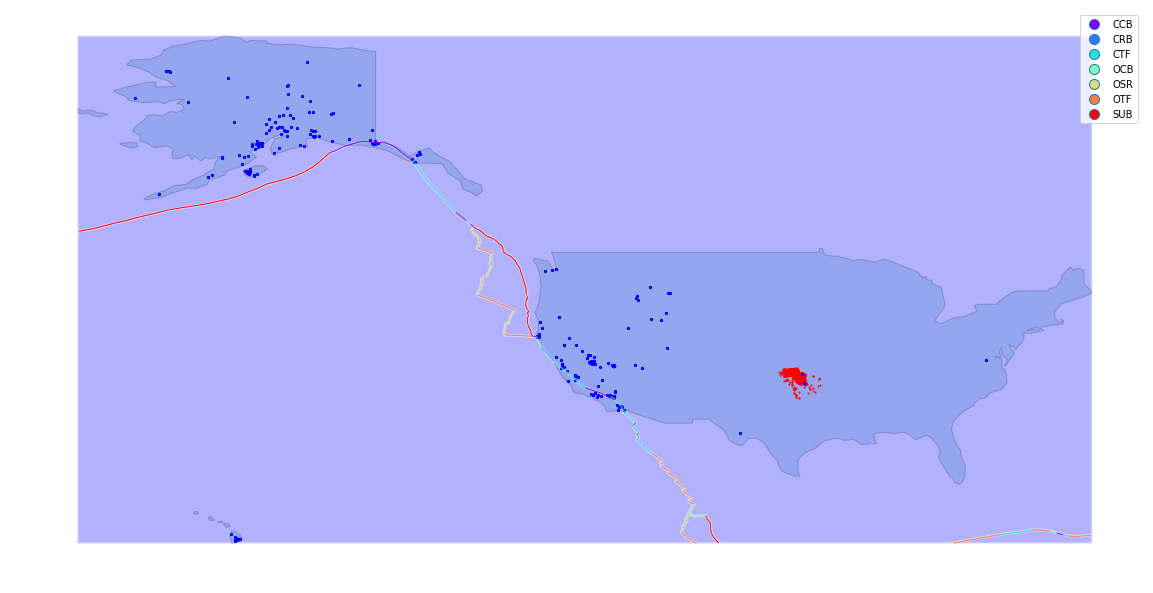

In [87]:
# Thanks to previous processing we will see a zoomed in version of previous maps that has just the US
# and earthquakes within its bounds

fig, ax = plt.subplots(figsize = (20, 20))
ax.set_aspect('equal')
plates_intersection.plot(ax=ax, color='blue', edgecolor='white', alpha = 0.3, lw = 3.0)
USA_gdf.plot(ax=ax, edgecolor='black', alpha = 0.2)
boundaries_intersection.plot(ax=ax, column = "STEPCLASS", cmap = "rainbow", lw = 1, legend = True)
OK_2015_gdf.plot(ax=ax, color = "red", markersize = 1)
USA_quakes_2.plot(ax=ax, color = "blue", markersize = 5)
plt.axis('off');

# Run this if you want to save the graph
#plt.tight_layout()
#plt.savefig("quakes_USA_map.png", dpi=80, orientation='landscape');

# There is very little overlap so it is possible that there may be some underlying differences in the environment where the two populations of earthquakes occur that the models are able to capture